<a href="https://colab.research.google.com/github/ConnorSA/tutorials_ext/blob/master/GPR_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HOMO energy prediction with Gaussian process regression

Now let's reproduce the KRR results from the previous notebook with another kernel-based model, Gaussian Process regression (GPR).

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import ConstantKernel

import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import load_npz
import math, random

## Load and visualize data 

Once again, we load the data. Reminder: the input data x is an array that contains all 7k molecules of the QM7 dataset, represented by their Coulomb matrices, which were computed with the [Dscribe](https://www.sciencedirect.com/science/article/pii/S0010465519303042?via%3Dihub) package. The output data y is a list that contains the corresponding (pre-computed) HOMO energies.

In [ ]:
!wget https://github.com/fullmetalfelix/ML-CSC-tutorial/raw/master/data/qm7/cm.npz
!wget https://raw.githubusercontent.com/fullmetalfelix/ML-CSC-tutorial/master/data/qm7/HOMO.txt

x = load_npz("cm.npz").toarray()
y = np.genfromtxt("HOMO.txt")

--2022-05-10 08:01:14--  https://github.com/fullmetalfelix/ML-CSC-tutorial/raw/master/data/qm7/cm.npz
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/fullmetalfelix/ML-CSC-tutorial/master/data/qm7/cm.npz [following]
--2022-05-10 08:01:14--  https://raw.githubusercontent.com/fullmetalfelix/ML-CSC-tutorial/master/data/qm7/cm.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3638980 (3.5M) [application/octet-stream]
Saving to: ‘cm.npz.2’

cm.npz.2            100%[===================>]   3.47M  --.-KB/s    in 0.07s   

2022-05-10 08:01:14 (52.3 MB/s) - ‘cm.npz.2’ saved [3638980/3638980]

--2022-05

Next, shuffle and divide the dataset into test-train split.

In [ ]:
## shuffle the data

c = list(zip(x, y))
random.shuffle(c)

x, y = zip(*c)

x = np.array(x)
y = np.array(y)

# decide how many samples to take from the database for training and testing
n_train = 1000
n_test = 1000

# split data in training and test
# take first n_train molecules for training
x_train  = x[0:n_train] 
y_train = y[0:n_train]

# take the next n_test data for testing
x_test = x[n_train:n_train + n_test]
y_test = y[n_train:n_train + n_test]

## Kernel setup

The first step in GPR is to define a kernel. In this example, we'll use the Gaussian kernel (also called the squared exponential SE or the radial basis function RBF kernel). This will make the fitting exactly compatible with the KRR example we did earlier.

Please note that scikit-learn package [defines the RBF kernel](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RBF.html#sklearn.gaussian_process.kernels.RBF) as the exponential function only, without the scaling factor multiplying it. This is why we will multiply it with a [Constant kernel C](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.ConstantKernel.html?highlight=constantkernel#sklearn.gaussian_process.kernels.ConstantKernel), to obtain the standard experssion for the Gaussian, which is used in other packages. Kernel development is an active field of research in GPR. The product or sum of kernels is another valid kernel.

## Kernel hyperparameters
Our composite C*RBF kernel has a couple of parameters: the constant value (for C) and the Gaussian lengthscale (for RBF). These are fitted in an automated way alongside with model fitting, by maximising the logarithm of the marginal likelihood in the hyperparameter search space. In practice, this translates into a bounded search for each hyperparameter. 

For each parameter search, we need to define the initial value (to start the search) and the lower and upper bounds. The bounds are often defined as a factor (e.g. x=1e2) dividing/multiplying the initial value.

**PRO TIP:** when approaching a new dataset, keep bounds large (x=1e4) until you see where the hyperparameters are converging, then adjust the starting position and reduce the x to 100, which makes the search faster. 

In [ ]:
# Define the initial values of hyperparameters and the search bounds
const, bound, length = 4, 1e2, 100

# Construct the kernel
kernel = ConstantKernel(
        constant_value=const,
        # hyperparameter bounded search: lower bound, upper bound
        constant_value_bounds=(const * 1.0 / bound, const * bound),) \
        * RBF(length_scale=length,
        # hyperparameter bounded search: lower bound, upper bound
        length_scale_bounds=(length * 1.0 / bound, length * bound),)

## GPR model

Given the kernel K=C*RBF above, let's proceed to construct the [GPR model](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html?highlight=gaussianprocessregressor#sklearn.gaussian_process.GaussianProcessRegressor). The main entries are the kernel K and the data noise parameter alpha. Alpha represent a native measure of data variation (usually very small in computations) and is added to the diagonal of the K during model fitting. Very small alpha values (1e-12) can lead to unstable algorithm performance (matrix inversion), so even if you have no noise, it is recommended to set at least alpha to 1e-8, if not larger.

Other GPR model options are related to the fitting procedure. The model may perform better/worse if you normalize your data, please check when starting with a new dataset. Also: the hyperparameter search proceeds via local minimisers from the initial hyperparameter value supplied in the kernel, so it's advised to perform several random restarts (at least 2) to check if an even better hyperparameter solution can be found. Please check this when starting with a new dataset, in case the initial settings are not optimal. 

**PRO TIP**: When starting with a new dataset, the initial hyperparameter values may be suboptimal, so please use several restarts and check optimal solutions. Then you can supply a good starting location for hyperparamers and reduce (costly) restarts. Similarly with the noise parameter alpha: with new data, it is recommended to perform an exploratory grid search, slowly increasing alpha from 1e-8 (very small) to 1e-1 (too large). The optimal value of alpha produces the best model accuracy and prevents overfitting.

In [ ]:
gpr = GaussianProcessRegressor(
      kernel=kernel,   # K=C*RBF
      alpha=0.0001,    # data noise
      normalize_y=True,
      n_restarts_optimizer=2, # random restarts for the hyperparameter search
      random_state=1234)           

## Model training

Next, let's fit the model on the training set data. After the fit, kernel parameters will have changed to optimal values. Please inspect them and record the values. NOTE: different values of noise can lead to different optimal hyperparameter solutions.

In [ ]:
gpr.fit(x_train, y_train)
    
# This prints an exhaustive list of all settings relevant to GPR
print(f"trained params : {gpr.get_params()}")

# This prints the optimal hyperparameters of the kernel
print(f"trained params : {gpr.kernel_}")

trained params : {'alpha': 0.0001, 'copy_X_train': True, 'kernel__k1': 2**2, 'kernel__k2': RBF(length_scale=100), 'kernel__k1__constant_value': 4, 'kernel__k1__constant_value_bounds': (0.04, 400.0), 'kernel__k2__length_scale': 100, 'kernel__k2__length_scale_bounds': (1.0, 10000.0), 'kernel': 2**2 * RBF(length_scale=100), 'n_restarts_optimizer': 2, 'normalize_y': True, 'optimizer': 'fmin_l_bfgs_b', 'random_state': 1234}
trained params : 1.18**2 * RBF(length_scale=27.6)


# Evaluating results

There are two key results from a GPR fit: GP posterior mean *y_mean* and the GP posterior variance (*y_std*)^2 (measure of confidence on the mean). The GP posterior mean is the data prediction. We can evaluate these for each data entry in our test set to compute the mean absolute error and evaluate model performance: the perfomance seems to be similar to the KRR model.  

In [ ]:
# scikit-learn automatically takes the best hyperparameter combination from the model training.
y_mean, y_std = gpr.predict(x_test, return_std=True)  

mae = (np.abs(y_mean - y_test)).mean()
print("Mean absolute error on test set: %0.3f eV" %mae)

Mean absolute error on test set: 0.298 eV


It is very useful to obtain GPR estimates on where the model is uncertain. Let's visualise the distribution of predictive uncertainties across the entire test set. Here, overall, the model is relatively uncertain (average uncertainties > average MAE), indicating that more data is needed for better quality predictions.


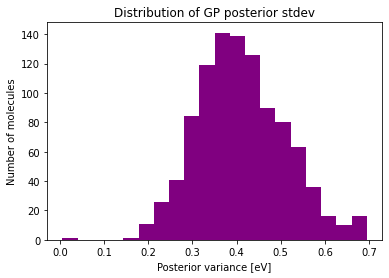

Mean value of GP posterior standard deviation on testset predictions: 0.41 eV


In [ ]:
plt.hist(y_std, bins=20, density=False, facecolor='purple')
plt.xlabel("Posterior variance [eV]")
plt.ylabel("Number of molecules")
plt.title("Distribution of GP posterior stdev")
plt.show()

## mean value of distribution
print("Mean value of GP posterior standard deviation on testset predictions: %0.2f eV" %np.mean(y_std))

## **Exercises**

### 1. Noise

Take a note of the current MAE and try adjusting the noise by a factor of 10 or 100 lower or higher. How does this change the MAE and the average standard deviation? Which alpha noise setting produces the lowest MAE for this dataset size? 

### 2. Hyperparameter search

Check fitted values for hyperparameters against the values of the hyperparameter bounds - if the final result is the same as the bound, they need to be adjusted. Also, try switching off the restarts, and increasing the no. of restarts - do the final hyperparameters change, and how does this affect the MAE? 

### 3. Initial hyperparameters

Try varing the initial hyperparameters by a factor of 10 (larger and smaller): how does this change the final hyperparameters and the MAE?

### 4. Dataset size

Having found the optimal settings for the GPR (noise, hyperparameter initial values, bounds, etc.), try increasing the training set size and check that the MAE is reduced. How does this affect the average GP model standard deviation?